In [1]:
import numpy as np
import sqlite3
import pandas as pd
from itertools import product
import joblib
from sklearn.preprocessing import MultiLabelBinarizer
import os
class a:
    @staticmethod
    def get_spectral_data(db_path, element, sp_num):
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        query = """
            SELECT "obs_wl_air(nm)", "gA(s^-1)", "Ek(cm-1)", "Ei(cm-1)", "g_i", "g_k"
            FROM spectrum_data
            WHERE element = ? AND sp_num = ?
        """
        cursor.execute(query, (element, sp_num))
        data = cursor.fetchall()
        conn.close()
        return data
    @staticmethod
    def save_spectrum_to_db(conn, sample_key, wavelengths, intensities):
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS simulated_spectra (
                sample_key TEXT,
                wavelength REAL,
                intensity REAL,
                PRIMARY KEY (sample_key, wavelength)
            )
        """)
        cursor.executemany("""
            INSERT OR REPLACE INTO simulated_spectra (sample_key, wavelength, intensity)
            VALUES (?, ?, ?)
        """, zip([sample_key]*len(wavelengths), wavelengths, intensities))
        conn.commit()

class b:
    def calculate_intensity(T, energy, degeneracy, einstein_coeff, Z):
        k_B = 8.617333262145e-5
        intesity = (degeneracy*(np.exp(-energy / ( T/10)))*einstein_coeff)/Z
        return intesity
    def partition_function(energy_levels, degeneracies, T):
        k_B = 8.617333262145e-5
        Z = np.sum([g * np.exp(-E / (T/10)) for g, E in zip(degeneracies, energy_levels)])
        return Z
    def gaussian_profile(x, center, sigma):
        return np.exp(-0.5 * ((x - center) / sigma) ** 2) / (sigma * np.sqrt(2 * np.pi))
    def simulate_spectrum(db_path, element, sp_num, temperature, resolution):
        spectral_data = a.get_spectral_data(db_path, element, sp_num)
        wavelengths = np.linspace(200, 900, resolution)
        intensities = np.zeros_like(wavelengths)
    
        energy_levels = []
        degeneracies = []
        selected_lines = []
    
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek, Ei = float(Ek), float(Ei)
                    Ei = Ei / 8065.544
                    gi = float(gi)
                    energy_levels.append(Ei)
                    degeneracies.append(gi)
                    selected_lines.append((wl, gA, Ei, gi))
                except ValueError:
                    continue
    
        Z = b.partition_function(energy_levels, degeneracies, temperature)
    
        for wl, gA, Ek, Ei, gi, gk in spectral_data:
            if all(value is not None and value != '' for value in [wl, gA, Ek, Ei, gi, gk]):
                try:
                    wl = float(wl)
                    gA = float(gA)
                    Ek = float(Ek)
                    Ek = Ek / 8065.544
                    gi = float(gi)
                    gk = float(gk)
                    Aki = gA/gk
                    intensity = b.calculate_intensity(temperature, Ek, gk, Aki, Z)
                    sigma = 0.1
                    intensities += intensity * b.gaussian_profile(wavelengths, wl, sigma)
                except ValueError:
                    continue
    
        return wavelengths, intensities, selected_lines


db_path = 'data1.db'
output_db_path = 'simulated_spectra.db'
resolution = 24880
elements = ['Ca']
ion_stages = [1, 2]
temperatures = list(range(5, 20, 1))

all_combinations = list(product(elements, ion_stages, temperatures))
all_data = pd.DataFrame(all_combinations, columns=['elements', 'ion_stages', 'temperatures'])


mlb_elements = MultiLabelBinarizer(classes=elements)
mlb_ion_stage = MultiLabelBinarizer(classes=[str(stage) for stage in ion_stages])


joblib.dump(mlb_elements.fit([elements]), 'mlb_elements.joblib')
joblib.dump(mlb_ion_stage.fit([[str(stage)] for stage in ion_stages]), 'mlb_ion_stage.joblib')



if os.path.exists(output_db_path):
    os.remove(output_db_path)

with sqlite3.connect(output_db_path) as conn:
    completed = 0
    total_combinations = len(all_combinations)
    for comb in all_combinations:
        element, ion_stage, temperature = comb
        sample_key = f"{element}_{ion_stage}_{temperature}"
        wavelengths, intensities, selected_lines = b.simulate_spectrum(db_path, element, ion_stage, temperature, resolution)
        pd.DataFrame(selected_lines).to_csv(f"outline/selected_lines{sample_key}.csv", index=False)
        a.save_spectrum_to_db(conn, sample_key, wavelengths, intensities)
        completed += 1
        progress = (completed / total_combinations) * 100
        print(f"Simulating spectra : {progress:.6f}% ({completed}/{total_combinations}  completed)", end='\r')

print("\nSelesai", output_db_path)

Simulating spectra : 100.000000% (30/30  completed)
Selesai simulated_spectra.db


In [1]:
elements = ['Fe', 'O', 'Na', 'Ca', 'Mg', 'Si', 'Al', 'K', 'Ti', 'Cr']
ion_stages = [1, 2]

In [2]:
import tkinter as tk
from tkinter import ttk, messagebox
import sqlite3
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import joblib

# Load the MultiLabelBinarizer encoders
mlb_elements = joblib.load('mlb_elements.joblib')
mlb_ion_stage = joblib.load('mlb_ion_stage.joblib')

# Extract categories for the combobox selections
elements = mlb_elements.classes_.tolist()
ion_stages = list(map(int, mlb_ion_stage.classes_))
temperatures = list(range(5, 20, 1))  # Temperature range based on the dataset

# Construct sample_key based on the element, ion_stage, and temperature
def generate_sample_key(element, ion_stage, temperature):
    return f"{element}_{ion_stage}_{temperature}"

# Function to plot spectrum without density
def plot_spectrum(db_path, element, ion_stage, temperature, canvas_container):
    sample_key = generate_sample_key(element, ion_stage, temperature)

    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    cursor.execute("""
        SELECT wavelength, intensity
        FROM simulated_spectra
        WHERE sample_key = ?
    """, (sample_key,))
    data = cursor.fetchall()
    conn.close()

    if data:
        wavelengths, intensities = zip(*data)
        fig = plt.Figure(figsize=(8, 6))
        ax = fig.add_subplot(111)
        ax.plot(wavelengths, intensities, label=f'{element} Ion Stage {ion_stage}')
        ax.set_xlabel('Wavelength (nm)')
        ax.set_ylabel('Intensity')
        ax.set_title(f'Spectrum at T={temperature/10}K')
        ax.legend()
        ax.grid()

        # Clear previous plots
        for widget in canvas_container.winfo_children():
            widget.destroy()

        canvas = FigureCanvasTkAgg(fig, master=canvas_container)
        canvas.draw()
        canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=1)
    else:
        messagebox.showerror("Data Not Found", "No data found for the specified parameters.")

# Main application window
root = tk.Tk()
root.title("Spectrum Plotter")

input_frame = ttk.Frame(root)
input_frame.pack(side=tk.TOP, fill=tk.X, padx=10, pady=10)

plot_frame = ttk.Frame(root)
plot_frame.pack(side=tk.TOP, fill=tk.BOTH, expand=1)

# User interface components without density
element_label = ttk.Label(input_frame, text="Element:")
element_label.grid(row=0, column=0, padx=5, pady=5, sticky=tk.W)
element_var = tk.StringVar()
element_combo = ttk.Combobox(input_frame, textvariable=element_var)
element_combo['values'] = elements
element_combo.current(0)
element_combo.grid(row=0, column=1, padx=5, pady=5)

ion_stage_label = ttk.Label(input_frame, text="Ion Stage:")
ion_stage_label.grid(row=1, column=0, padx=5, pady=5, sticky=tk.W)
ion_stage_var = tk.IntVar()
ion_stage_combo = ttk.Combobox(input_frame, textvariable=ion_stage_var)
ion_stage_combo['values'] = ion_stages
ion_stage_combo.current(0)
ion_stage_combo.grid(row=1, column=1, padx=5, pady=5)

temperature_label = ttk.Label(input_frame, text="Temperature (K):")
temperature_label.grid(row=2, column=0, padx=5, pady=5, sticky=tk.W)
temperature_var = tk.IntVar()
temperature_combo = ttk.Combobox(input_frame, textvariable=temperature_var)
temperature_combo['values'] = temperatures
temperature_combo.current(0)
temperature_combo.grid(row=2, column=1, padx=5, pady=5)

# Function to handle plot button click
def on_plot_button_click():
    element = element_var.get()
    ion_stage = int(ion_stage_var.get())
    temperature = int(temperature_var.get())
    db_path = 'simulated_spectra.db'

    plot_spectrum(db_path, element, ion_stage, temperature, plot_frame)

plot_button = ttk.Button(input_frame, text="Plot Spectrum", command=on_plot_button_click)
plot_button.grid(row=3, column=0, columnspan=2, pady=10)

root.mainloop()

2024-11-06 17:18:02.252 Python[22759:1022037] +[IMKClient subclass]: chose IMKClient_Modern
2024-11-06 17:18:02.252 Python[22759:1022037] +[IMKInputSession subclass]: chose IMKInputSession_Modern


In [10]:
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import joblib

# Fungsi untuk memuat data dari database dan mengekstrak elemen+ion stage sebagai label
def load_data(db_path):
    conn = sqlite3.connect(db_path)
    query = """
        SELECT sample_key, wavelength, intensity
        FROM simulated_spectra
    """
    data = pd.read_sql_query(query, conn)
    conn.close()
    
    # Ekstraksi elemen+ion stage dari sample_key sebagai label
    data['element_ion'] = data['sample_key'].apply(lambda x: '_'.join(x.split('_')[:2]))
    
    return data

# Fungsi untuk mengekstrak puncak dari spektrum
def extract_peaks(data, percentile=90):
    spectra_list = []
    element_ion_labels = []

    for sample_key, group in data.groupby('sample_key'):
        group = group.sort_values('wavelength')
        
        # Identifikasi puncak berdasarkan persentil
        threshold = np.percentile(group['intensity'], percentile)
        peak_points = group[group['intensity'] >= threshold]
        
        # Ambil intensitas dan panjang gelombang dari puncak
        peak_wavelengths = peak_points['wavelength'].values
        peak_intensities = peak_points['intensity'].values
        
        # Jika hanya ada satu puncak, tambahkan nilai default atau abaikan sampel
        if len(peak_intensities) > 1:
            # Rasio antar puncak
            ratios = peak_intensities[1:] / peak_intensities[:-1]
            spectra_list.append(ratios)
            element_ion_labels.append(group['element_ion'].iloc[0])
    
    return spectra_list, element_ion_labels

# Muat dan proses data
db_path = 'simulated_spectra.db'
data = load_data(db_path)
spectra_list, element_ion_labels = extract_peaks(data)

# Pad atau potong panjang rasio untuk keseragaman
max_len = max(len(s) for s in spectra_list)
spectra_array = np.array([np.pad(s, (0, max_len - len(s)), 'constant') for s in spectra_list])

# Encode label elemen+ion stage
label_encoder = LabelEncoder()
element_ion_encoded = label_encoder.fit_transform(element_ion_labels)

# Bagi data menjadi set latih dan uji
X_train, X_test, y_train, y_test = train_test_split(
    spectra_array, element_ion_encoded, test_size=0.2, random_state=42
)

# Bentuk data untuk input LSTM: (n_samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Membuat model LSTM untuk klasifikasi berdasarkan rasio puncak
def create_peak_ratio_model(input_shape, num_classes):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

# Inisialisasi parameter model
input_shape = (X_train.shape[1], 1)  # Bentuk input LSTM
num_classes = len(label_encoder.classes_)

# Membuat dan mengkompilasi model
model = create_peak_ratio_model(input_shape, num_classes)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Melatih model
history = model.fit(X_train, y_train,
                    validation_data=(X_test, y_test),
                    epochs=20,
                    batch_size=32)

# Menyimpan model yang telah dilatih dan encoder label
model.save('lstm_peak_ratio_model.keras')
joblib.dump(label_encoder, 'element_ion_label_encoder.pkl')

print("Model dan label encoder telah disimpan.")

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 396ms/step - accuracy: 0.7732 - loss: 0.6868 - val_accuracy: 1.0000 - val_loss: 0.6544
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 1.0000 - loss: 0.6460 - val_accuracy: 1.0000 - val_loss: 0.5785
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 0.9929 - loss: 0.5589 - val_accuracy: 1.0000 - val_loss: 0.4728
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 1.0000 - loss: 0.4396 - val_accuracy: 1.0000 - val_loss: 0.3630
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 1.0000 - loss: 0.3506 - val_accuracy: 1.0000 - val_loss: 0.2591
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 343ms/step - accuracy: 1.0000 - loss: 0.2196 - val_accuracy: 1.0000 - val_loss: 0.1497
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 344ms/step - accuracy: 1.0000 - loss: 0.1351 - val_accuracy: 1.0000 - val_loss: 0.0859
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step - accuracy: 1.0000 - loss: 0.0778 - val_accuracy: 1.0000 - val_loss: 0.0388
Epo

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

# Memuat model
model = load_model('lstm_element_ion_with_temp_model.keras')

# Menampilkan ringkasan model
print("Model Summary:")
model.summary()

# Menampilkan detail setiap input layer
print("\nInput Layer Details:")
for layer in model.inputs:
    print(f"Input Layer Name: {layer.name}, Shape: {layer.shape}")

# Menampilkan detail setiap output layer
print("\nOutput Layer Details:")
for layer in model.outputs:
    print(f"Output Layer Name: {layer.name}, Shape: {layer.shape}")

# Menampilkan detail lengkap setiap layer dalam model
print("\nFull Layer Details:")
for layer in model.layers:
    print(f"Layer Name: {layer.name}")
    print(f"  Layer Type: {type(layer)}")
    # Gunakan try-except untuk menangani layer yang tidak memiliki atribut input_shape/output_shape
    try:
        print(f"  Input Shape: {layer.input_shape}")
        print(f"  Output Shape: {layer.output_shape}")
    except AttributeError:
        # Gunakan layer.input dan layer.output jika input_shape/output_shape tidak tersedia
        print(f"  Input: {layer.input}")
        print(f"  Output: {layer.output}")
    print("-" * 40)

Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ spectra_input       │ (None, 24880, 1)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 24880,     │     66,560 │ spectra_input[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ temp_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 65)        │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ temp_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ element_ion_output  │ (None, 2)         │        132 │ concatenate[0][0] │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 348,302 (1.33 MB)

 Trainable params: 116,100 (453.52 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 232,202 (907.04 KB)


Input Layer Details:
Input Layer Name: spectra_input, Shape: (None, 24880, 1)
Input Layer Name: temp_input, Shape: (None, 1)

Output Layer Details:
Output Layer Name: keras_tensor_32, Shape: (None, 2)

Full Layer Details:
Layer Name: spectra_input
  Layer Type: <class 'keras.src.layers.core.input_layer.InputLayer'>
  Input: []
  Output: <KerasTensor shape=(None, 24880, 1), dtype=float32, sparse=False, name=spectra_input>
----------------------------------------
Layer Name: lstm
  Layer Type: <class 'keras.src.layers.rnn.lstm.LSTM'>
  Input: <KerasTensor shape=(None, 24880, 1), dtype=float32, sparse=False, name=spectra_input>
  Output: <KerasTensor shape=(None, 24880, 128), dtype=float32, sparse=False, name=keras_tensor_23>
----------------------------------------
Layer Name: lstm_1
  Layer Type: <class 'keras.src.layers.rnn.lstm.LSTM'>
  Input: <KerasTensor shape=(None, 24880, 128), dtype=float32, sparse=False, name=keras_tensor_23>
  Output: <KerasTensor shape=(None, 64), dtype=float

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


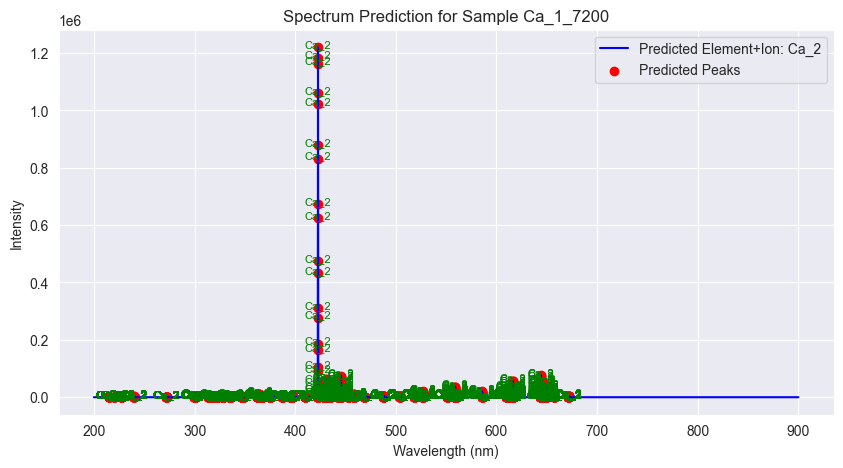

In [11]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
import joblib

# Memuat model dan label encoder
model = load_model('lstm_element_ion_model.keras')
label_encoder = joblib.load('element_ion_label_encoder.pkl')

# Fungsi untuk memuat spektrum dari database berdasarkan sample_key
def load_specific_spectrum(db_path, sample_key):
    conn = sqlite3.connect(db_path)
    query = """
        SELECT sample_key, wavelength, intensity
        FROM simulated_spectra
        WHERE sample_key = ?
    """
    data = pd.read_sql_query(query, conn, params=(sample_key,))
    conn.close()
    return data

# Tentukan sample_key dari spektrum yang ingin diprediksi
sample_key = 'Ca_1_7200'  # Ganti dengan sample_key yang diinginkan

# Memuat data spektrum tertentu dari database
data = load_specific_spectrum('simulated_spectra.db', sample_key)

# Cek apakah data tersedia
if data.empty:
    print(f"Tidak ada data yang ditemukan untuk sample_key '{sample_key}'.")
else:
    # Praproses data untuk prediksi
    def preprocess_data_for_prediction(data):
        # Urutkan data berdasarkan panjang gelombang
        group = data.sort_values('wavelength')
        intensities = group['intensity'].values
        spectra_array = np.array([intensities])  # Menambah dimensi agar sesuai input model (1, timesteps)
        return spectra_array

    spectra_array = preprocess_data_for_prediction(data)

    # Ubah bentuk data untuk prediksi
    spectra_array = spectra_array.reshape((1, spectra_array.shape[1], 1))  # Bentuk (1, timesteps, 1)

    # Melakukan prediksi dengan model
    predictions = model.predict(spectra_array)
    
    # Mendekode hasil prediksi ke label element_ion asli
    predicted_label = label_encoder.inverse_transform(np.argmax(predictions, axis=1))[0]
    
    # Menampilkan hasil prediksi dengan spektrum asli dan puncak intensitas
    plt.figure(figsize=(10, 5))
    plt.plot(data['wavelength'], data['intensity'], label=f"Predicted Element+Ion: {predicted_label}", color='blue')

    # Cari puncak intensitas
    peak_indices = np.where(data['intensity'] > np.percentile(data['intensity'], 90))[0]  # Puncak di atas persentil 90
    peaks_wavelengths = data['wavelength'].values[peak_indices]
    peaks_intensities = data['intensity'].values[peak_indices]

    # Plot titik puncak
    plt.scatter(peaks_wavelengths, peaks_intensities, color='red', label="Predicted Peaks")
    
    # Menampilkan label puncak
    for wl, intensity in zip(peaks_wavelengths, peaks_intensities):
        plt.text(wl, intensity, f"{predicted_label}", fontsize=8, ha='center', color='green')

    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Intensity")
    plt.title(f"Spectrum Prediction for Sample {sample_key}")
    plt.legend()
    plt.show()

In [4]:
#MultiVariate Stacked LSTM
import numpy as np
import pandas as pd
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate

# Fungsi untuk memuat data dari database
def load_data(db_path):
    conn = sqlite3.connect(db_path)
    query = """
        SELECT sample_key, wavelength, intensity
        FROM simulated_spectra
    """
    data = pd.read_sql_query(query, conn)
    conn.close()
    return data

data = load_data('simulated_spectra.db')

# Ekstraksi unsur_ion dan suhu dari sample_key
data['element_ion'] = data['sample_key'].apply(lambda x: '_'.join(x.split('_')[:2]))
data['temperature'] = data['sample_key'].apply(lambda x: float(x.split('_')[2]))

# Konversi unsur_ion menjadi label numerik
label_encoder_element_ion = LabelEncoder()
data['element_ion_encoded'] = label_encoder_element_ion.fit_transform(data['element_ion'])

# Fungsi untuk praproses data
def preprocess_data(data):
    spectra_list = []
    temperature_list = []
    element_ion_labels = []

    # Mengelompokkan data berdasarkan sample_key
    for sample_key, group in data.groupby('sample_key'):
        group = group.sort_values('wavelength')
        intensities = group['intensity'].values
        temperature = group['temperature'].iloc[0]
        
        # Menyimpan data intensitas, suhu, dan label yang dipisah
        spectra_list.append(intensities)
        temperature_list.append(temperature)
        element_ion_labels.append(group['element_ion_encoded'].iloc[0])

    spectra_array = np.array(spectra_list)
    temperature_array = np.array(temperature_list)
    return spectra_array, temperature_array, element_ion_labels

spectra_array, temperature_array, element_ion_labels = preprocess_data(data)

# Memisahkan data menjadi data latih dan uji
X_train_spectra, X_test_spectra, X_train_temp, X_test_temp, y_train_element_ion, y_test_element_ion = train_test_split(
    spectra_array, temperature_array, element_ion_labels, test_size=0.2, random_state=42
)

# Ubah bentuk data untuk model LSTM
X_train_spectra = X_train_spectra.reshape((X_train_spectra.shape[0], X_train_spectra.shape[1], 1))
X_test_spectra = X_test_spectra.reshape((X_test_spectra.shape[0], X_test_spectra.shape[1], 1))

# Fungsi untuk membuat model Multivariate Stacked LSTM dengan suhu sebagai input tambahan
def create_stacked_lstm_with_temperature_model(spectra_shape, num_element_ion):
    # Input untuk spektrum intensitas
    spectra_input = Input(shape=spectra_shape, name='spectra_input')
    x = LSTM(128, return_sequences=True)(spectra_input)
    x = LSTM(64, return_sequences=True)(x)  # Layer LSTM tambahan untuk memperdalam jaringan
    x = LSTM(32)(x)
    x = Dropout(0.2)(x)
    
    # Input untuk suhu
    temp_input = Input(shape=(1,), name='temp_input')
    
    # Menggabungkan spektrum dan suhu
    combined = Concatenate()([x, temp_input])
    
    # Output untuk klasifikasi element_ion
    element_ion_output = Dense(num_element_ion, activation='softmax', name='element_ion_output')(combined)
    
    model = Model(inputs=[spectra_input, temp_input], outputs=element_ion_output)
    return model

# Inisialisasi parameter model
spectra_shape = (X_train_spectra.shape[1], X_train_spectra.shape[2])
num_element_ion = len(label_encoder_element_ion.classes_)

# Membuat dan mengkompilasi model Stacked LSTM
model = create_stacked_lstm_with_temperature_model(spectra_shape, num_element_ion)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Melatih model
history = model.fit([X_train_spectra, X_train_temp], np.array(y_train_element_ion),
                    validation_data=([X_test_spectra, X_test_temp], np.array(y_test_element_ion)),
                    epochs=30, 
                    batch_size=32)

# Menyimpan model yang telah dilatih
model.save('stacked_lstm_element_ion_with_temp_model.keras')

# Menyimpan label encoder untuk element_ion
import joblib
joblib.dump(label_encoder_element_ion, 'element_ion_label_encoder.pkl')

print("Model dan label encoder telah disimpan.")

DatabaseError: Execution failed on sql '
        SELECT sample_name, wavelength, intensity
        FROM processed_spectrum
    ': no such table: processed_spectrum

In [15]:
import numpy as np
import pandas as pd
import sqlite3
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

# Fungsi untuk memuat model dan melakukan prediksi rekonstruksi pada spektrum tanah vulkanik
def predict_soil_spectrum(model_path, db_path, sample_name):
    # Muat model yang telah dilatih
    model = tf.keras.models.load_model(model_path)

    # Buka koneksi ke database dan ambil data intensitas untuk `sample_name` tertentu
    conn = sqlite3.connect(db_path)
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
        ORDER BY wavelength
    """
    data = pd.read_sql_query(query, conn, params=(sample_name,))
    conn.close()

    # Jika data kosong, beri pesan dan hentikan proses
    if data.empty:
        print(f"Tidak ada data yang ditemukan untuk sample_name: {sample_name}")
        return

    # Ambil data panjang gelombang dan intensitas
    wavelengths = data['wavelength'].values
    intensities = data['intensity'].values

    # Interpolasi ke 24.880 titik dalam rentang 200 hingga 900 nm
    wavelengths_resampled = np.linspace(wavelengths.min(), wavelengths.max(), 24880)
    interp_func = interp1d(wavelengths, intensities, kind='linear')
    intensities_resampled = interp_func(wavelengths_resampled)

    # Siapkan data untuk prediksi oleh model (input berbentuk (1, 24880, 1))
    intensities_input = intensities_resampled.reshape((1, 24880, 1))

    # Lakukan prediksi rekonstruksi intensitas spektrum
    predictions = model.predict(intensities_input)

    # Pastikan `predictions` berbentuk seperti yang diharapkan
    predicted_intensities = predictions.squeeze()
    if predicted_intensities.shape != (24880,):
        print(f"Prediksi memiliki bentuk yang tidak diharapkan: {predicted_intensities.shape}")
        return

    # Temukan puncak dalam intensitas spektrum asli untuk membandingkan
    peaks, _ = find_peaks(intensities_resampled, height=0.09)  

    # Plot hasil prediksi rekonstruksi bersama spektrum asli
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths_resampled, intensities_resampled, label=f'Spektrum Asli ({sample_name})', color='blue')
    plt.plot(wavelengths_resampled, predicted_intensities, label='Spektrum Rekonstruksi', linestyle='--', color='orange')
    plt.xlabel('Panjang Gelombang (nm)')
    plt.ylabel('Intensitas')
    plt.title(f'Rekonstruksi Spektrum untuk Sampel: {sample_name}')
    plt.grid()

    # Tandai puncak pada spektrum asli untuk referensi
    plt.plot(wavelengths_resampled[peaks], intensities_resampled[peaks], "ro", label="Puncak Spektrum Asli")
    
    plt.legend()
    plt.show()

# Panggil fungsi prediksi untuk spektrum tanah vulkanik
predict_soil_spectrum('lstm_spectrum_model.keras', 'processed_spectra.db', 'S1')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Prediksi memiliki bentuk yang tidak diharapkan: ()


In [10]:
import sqlite3

# Membuka koneksi ke database
conn = sqlite3.connect('tanah_vulkanik.db')
cursor = conn.cursor()

# Menjalankan query untuk mendapatkan nama kolom dari tabel processed_spectrum
cursor.execute("PRAGMA table_info(spectrum_data)")
columns = [column[1] for column in cursor.fetchall()]

# Menampilkan nama kolom
print("Nama kolom dalam tabel processed_spectrum:", columns)

# Menutup koneksi
conn.close()

Nama kolom dalam tabel processed_spectrum: ['id', 'sample_name', 'iteration', 'wavelength', 'intensity', 'depth', 'location', 'location_point']


In [12]:
import sqlite3

# Membuka koneksi ke database
conn = sqlite3.connect('tanah_vulkanik.db')
cursor = conn.cursor()

# Menjalankan query untuk menghitung jumlah data di kolom wavelength untuk setiap sample_name
cursor.execute("""
    SELECT sample_name, COUNT(wavelength) AS wavelength_count
    FROM spectrum_data
    GROUP BY sample_name
""")
results = cursor.fetchall()

# Menampilkan hasil
for sample, count in results:
    print(f"Sample '{sample}' memiliki {count} data di kolom wavelength.")

# Menutup koneksi
conn.close()

Sample 'S1' memiliki 149274 data di kolom wavelength.
Sample 'S10' memiliki 149274 data di kolom wavelength.
Sample 'S11' memiliki 149274 data di kolom wavelength.
Sample 'S12' memiliki 149274 data di kolom wavelength.
Sample 'S13' memiliki 149274 data di kolom wavelength.
Sample 'S14' memiliki 149274 data di kolom wavelength.
Sample 'S15' memiliki 149274 data di kolom wavelength.
Sample 'S16' memiliki 149274 data di kolom wavelength.
Sample 'S17' memiliki 149274 data di kolom wavelength.
Sample 'S18' memiliki 149274 data di kolom wavelength.
Sample 'S19' memiliki 149274 data di kolom wavelength.
Sample 'S2' memiliki 149274 data di kolom wavelength.
Sample 'S20' memiliki 149274 data di kolom wavelength.
Sample 'S21' memiliki 149274 data di kolom wavelength.
Sample 'S22' memiliki 149274 data di kolom wavelength.
Sample 'S23' memiliki 149274 data di kolom wavelength.
Sample 'S24' memiliki 149274 data di kolom wavelength.
Sample 'S3' memiliki 149274 data di kolom wavelength.
Sample 'S4' m

In [14]:
import sqlite3
import pandas as pd

# Membuka koneksi ke database
conn = sqlite3.connect('tanah_vulkanik.db')
cursor = conn.cursor()

# Menjalankan query untuk mendapatkan daftar sample_name unik
cursor.execute("SELECT DISTINCT sample_name FROM spectrum_data")
sample_names = [row[0] for row in cursor.fetchall()]

# Loop untuk setiap sample_name
for sample in sample_names:
    # Mendapatkan semua data dari kolom wavelength untuk sample_name tertentu
    query = f"""
        SELECT *
        FROM spectrum_data
        WHERE sample_name = ?
    """
    df = pd.read_sql_query(query, conn, params=(sample,))
    
    # Menyimpan DataFrame ke file Excel dengan nama file berdasarkan sample_name
    file_name = f"{sample}_spectrum_data.xlsx"
    df.to_excel(file_name, index=False)
    print(f"Data untuk sample '{sample}' telah disimpan di {file_name}")

# Menutup koneksi
conn.close()

Data untuk sample 'S10' telah disimpan di S10_spectrum_data.xlsx
Data untuk sample 'S1' telah disimpan di S1_spectrum_data.xlsx
Data untuk sample 'S23' telah disimpan di S23_spectrum_data.xlsx
Data untuk sample 'S11' telah disimpan di S11_spectrum_data.xlsx
Data untuk sample 'S22' telah disimpan di S22_spectrum_data.xlsx
Data untuk sample 'S12' telah disimpan di S12_spectrum_data.xlsx
Data untuk sample 'S20' telah disimpan di S20_spectrum_data.xlsx
Data untuk sample 'S2' telah disimpan di S2_spectrum_data.xlsx
Data untuk sample 'S3' telah disimpan di S3_spectrum_data.xlsx
Data untuk sample 'S21' telah disimpan di S21_spectrum_data.xlsx
Data untuk sample 'S13' telah disimpan di S13_spectrum_data.xlsx
Data untuk sample 'S14' telah disimpan di S14_spectrum_data.xlsx
Data untuk sample 'S4' telah disimpan di S4_spectrum_data.xlsx
Data untuk sample 'S5' telah disimpan di S5_spectrum_data.xlsx
Data untuk sample 'S15' telah disimpan di S15_spectrum_data.xlsx
Data untuk sample 'S16' telah disim